# Stock Market Prediction

Reading: https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944

## Libraries

In [1]:
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
import keras
import tensorflow
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging
import matplotlib
from google.colab import drive

print(keras.__version__)
print(tensorflow.__version__)
print(np.__version__)
print(matplotlib.__version__)

drive.mount('/content/gdrive')
BASE_PATH = '/content/gdrive/My Drive/Semester 3/IF5181 - Pattern Recognition/Hands On 2/';

Using TensorFlow backend.


2.2.5
1.15.0
1.17.4
3.1.1
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def build_timeseries(mat, y_col_index, time_steps=3):
    """
    y_col_index is the index of column that would act as output column
    total number of time-series samples would be len(mat) - time_steps
    """
    
    dim_0 = mat.shape[0] - time_steps
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, time_steps, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = mat[i:time_steps+i]
        y[i] = mat[time_steps+i, y_col_index]
    
    print("Shape of time-series i/o:", x.shape, y.shape)
    
    return x, y

def trim_dataset(mat, batch_size=10):
    """
    trims dataset to a size that's divisible by batch_size
    """
    no_of_rows_drop = mat.shape[0] % batch_size
    
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    
    return mat

## Preprocessing

In [3]:
INPUT_PATH = BASE_PATH + 'NSE-TATAGLOBAL.csv'
STOCK_NAME = 'NSE-TATAGLOBAL'

df = pd.read_csv(INPUT_PATH, engine='python')
df.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56


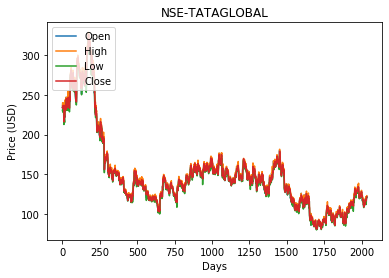

In [4]:
# Figuring data

from matplotlib import pyplot as plt

plt.figure()
plt.plot(df["Open"])
plt.plot(df["High"])
plt.plot(df["Low"])
plt.plot(df["Close"])
plt.title(STOCK_NAME)
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open', 'High', 'Low', 'Close'], loc='upper left')
plt.show()

In [5]:
print("checking if any null values are present\n", df.isna().sum())

checking if any null values are present
 Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64


In [6]:
train_cols = ["Open", "High", "Low", "Close", "Total Trade Quantity"]
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))

# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Train and Test size 1628 407


In [7]:
BATCH_SIZE = 20
TIME_STEPS = 60

x_t, y_t = build_timeseries(x_train, 3, TIME_STEPS)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3, TIME_STEPS)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE), 2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE), 2)

Shape of time-series i/o: (1568, 60, 5) (1568,)
Shape of time-series i/o: (347, 60, 5) (347,)


## Modeling Exercise

In [8]:
np.random.seed(1)

model = Sequential()
model.add(LSTM(
    128,
    batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
    dropout=0.0,
    recurrent_dropout=0.0,
    stateful=True,
    kernel_initializer='random_uniform'
    ))
model.add(Dropout(0.5))
model.add(Dense(20,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=0.0001)
model.compile(loss='mean_squared_error', optimizer=optimizer)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [9]:
csv_logger = CSVLogger('LOG.log', append=True)

history = model.fit(x_t, y_t, epochs=300, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1560 samples, validate on 160 samples
Epoch 1/300





 - 4s - loss: 0.0896 - val_loss: 0.2251
Epoch 2/300
 - 3s - loss: 0.0654 - val_loss: 0.0195
Epoch 3/300
 - 3s - loss: 0.0668 - val_loss: 0.0206
Epoch 4/300
 - 3s - loss: 0.0586 - val_loss: 0.0190
Epoch 5/300
 - 3s - loss: 0.0494 - val_loss: 0.0176
Epoch 6/300
 - 3s - loss: 0.0388 - val_loss: 0.0137
Epoch 7/300
 - 3s - loss: 0.0258 - val_loss: 0.0109
Epoch 8/300
 - 3s - loss: 0.0195 - val_loss: 0.0111
Epoch 9/300
 - 3s - loss: 0.0164 - val_loss: 0.0100
Epoch 10/300
 - 3s - loss: 0.0154 - val_loss: 0.0102
Epoch 11/300
 - 3s - loss: 0.0143 - val_loss: 0.0103
Epoch 12/300
 - 3s - loss: 0.0134 - val_loss: 0.0109
Epoch 13/300
 - 3s - loss: 0.0123 - val_loss: 0.0100
Epoch 14/300
 - 3s - loss: 0.0120 - val_loss: 0.0101
Epoch 15/300
 - 3s - loss: 0.0116 - val_loss: 0.0100
Epoch 16/300
 - 3s - loss: 0.0111 - val_loss: 0.0105
Epoch 17/300

### Test

In [10]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)

print("Error is", error, y_pred.shape, y_test_t.shape)

Error is 0.0010314142818132724 (160,) (160,)


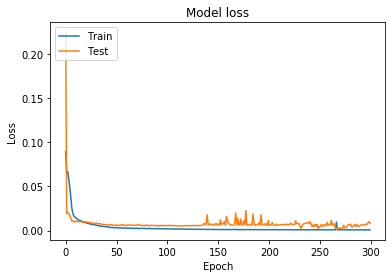

In [11]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Modeling Test

### Data Preprocessing

In [12]:
INPUT_PATH = BASE_PATH + 'JK_LQ45.csv'
STOCK_NAME = 'JK_LQ45'

df = pd.read_csv(INPUT_PATH, engine='python')
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1204,2019-11-11,979.059998,981.669983,974.349976,978.469971,978.469971,809309700
1205,2019-11-12,974.450012,984.219971,973.830017,984.219971,984.219971,942298400
1206,2019-11-13,982.880005,983.719971,971.890015,974.880005,974.880005,949609700
1207,2019-11-14,972.659973,974.640015,956.760010,964.580017,964.580017,998135800
1208,2019-11-15,969.929993,977.210022,963.989990,975.369995,975.369995,831118400


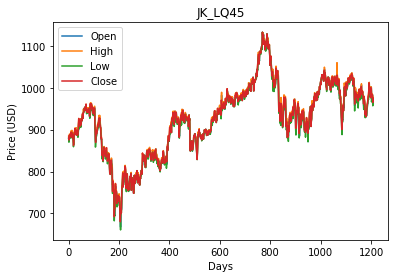

In [13]:
plt.figure()
plt.plot(df["Open"])
plt.plot(df["High"])
plt.plot(df["Low"])
plt.plot(df["Close"])
plt.title(STOCK_NAME)
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open', 'High', 'Low', 'Close'], loc='upper left')
plt.show()

In [14]:
print("checking if any null values are present\n", df.isna().sum())

checking if any null values are present
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [15]:
train_cols = ["Open", "High", "Low", "Close", "Volume"]
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))

# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler_test = MinMaxScaler()
x_train = min_max_scaler_test.fit_transform(x)
x_test = min_max_scaler_test.transform(df_test.loc[:,train_cols])

Train and Test size 967 242


In [16]:
BATCH_SIZE = 20
TIME_STEPS = 60

x_t, y_t = build_timeseries(x_train, 3, TIME_STEPS)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3, TIME_STEPS)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE), 2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE), 2)

Shape of time-series i/o: (907, 60, 5) (907,)
Shape of time-series i/o: (182, 60, 5) (182,)


### Modeling

In [0]:
np.random.seed(1)

model = Sequential()
model.add(LSTM(
    128,
    batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
    dropout=0.0,
    recurrent_dropout=0.0,
    stateful=True,
    kernel_initializer='random_uniform'
    ))
model.add(Dropout(0.5))
model.add(Dense(20,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=0.0001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [18]:
csv_logger = CSVLogger('LOG_TEST.log', append=True)

history = model.fit(x_t, y_t, epochs=300, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])

Train on 900 samples, validate on 80 samples
Epoch 1/300
 - 2s - loss: 0.0373 - val_loss: 0.0386
Epoch 2/300
 - 2s - loss: 0.0353 - val_loss: 0.0314
Epoch 3/300
 - 2s - loss: 0.0336 - val_loss: 0.0246
Epoch 4/300
 - 2s - loss: 0.0322 - val_loss: 0.0181
Epoch 5/300
 - 2s - loss: 0.0308 - val_loss: 0.0123
Epoch 6/300
 - 2s - loss: 0.0291 - val_loss: 0.0082
Epoch 7/300
 - 2s - loss: 0.0270 - val_loss: 0.0067
Epoch 8/300
 - 2s - loss: 0.0253 - val_loss: 0.0067
Epoch 9/300
 - 2s - loss: 0.0235 - val_loss: 0.0066
Epoch 10/300
 - 2s - loss: 0.0205 - val_loss: 0.0084
Epoch 11/300
 - 2s - loss: 0.0189 - val_loss: 0.0074
Epoch 12/300
 - 2s - loss: 0.0173 - val_loss: 0.0068
Epoch 13/300
 - 2s - loss: 0.0162 - val_loss: 0.0056
Epoch 14/300
 - 2s - loss: 0.0146 - val_loss: 0.0054
Epoch 15/300
 - 2s - loss: 0.0131 - val_loss: 0.0052
Epoch 16/300
 - 2s - loss: 0.0119 - val_loss: 0.0053
Epoch 17/300
 - 2s - loss: 0.0113 - val_loss: 0.0051
Epoch 18/300
 - 2s - loss: 0.0105 - val_loss: 0.0051
Epoch 19/3

### Test validation

In [19]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)

print("Error is", error, y_pred.shape, y_test_t.shape)

Error is 0.0017104010473672263 (80,) (80,)


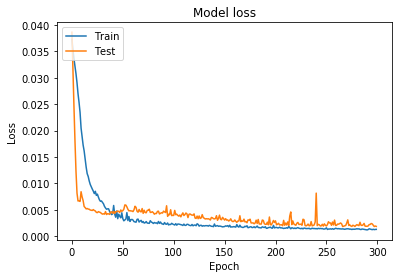

In [20]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()